<font color="#506F87" size=5.5><b>Extracción de características para el sistema CBIR</b></font>
<br>
La extracción de características de imágenes es un componente esencial en el análisis de contenido visual, desempeñando un papel crucial en la comprensión y clasificación de imágenes. En este contexto, hemos empleado diversas técnicas para extraer información discriminativa de nuestras imágenes. Hemos capturado la distribución de colores a través de histogramas, proporcionando una representación compacta de la información cromática presente en las imágenes. Además, hemos empleado descriptores robustos como SIFT y ORB para identificar puntos clave y describir sus entornos, facilitando así la detección de patrones distintivos. La utilización de mapas de características generados por modelos profundos como VGG-16 ha permitido capturar representaciones semánticas de alto nivel. Finalmente, hemos adoptado un enfoque de bag of words para condensar la información esencial de las imágenes en vectores cuantificados, estableciendo así una base sólida para futuras tareas de clasificación y reconocimiento visual. Estas descipciones de las imágenes se guardarán en un archivo con extensión <strong>.pkl</strong> para su posterior uso en queries.

<font color="#506F87" size=4.5><b>Autores</b></font>
- Mario Serrano Sanchéz
- Pablo Gómez Martín
- Cristina Sandoval Nuño
- Gonzalo Rivera del Pino

## <font color="#506F87" size=5.5><b>Librerías</b></font>

In [2]:
from random import randint
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import re
from torchvision import models
import os

from feature_extraction_functions import fast_kp, sift_descriptors_and_kp, orb_descriptors, feature_map
from feature_extraction_functions import preprocessing_for_CNN, get_histogram, get_tfidf
from visualization_functions import show_kp

## <font color="#506F87" size=5.5><b>Carga y preparación del dataset</b></font>

Cargamos del sistema de archivos las 50 imágenes seleccionadas para cada una de las 15 clases elegidas. Esto solo habrá que realizarlo una vez ya que para facilitar la transferencia entre dispositivos generaremos un archivo que guarde las imágenes

In [3]:
main_folder = './'

df = pd.DataFrame(columns=['image', 'label'])

# Cogemos solo 50 imágenes por categoría
max_images_per_class = 50

# Recorre las carpetas de imágenes
for folder_name in os.listdir(os.path.join(main_folder, 'images')):
    folder_path = os.path.join(main_folder, 'images', folder_name)

    if os.path.isdir(folder_path):
        for image_name in os.listdir(folder_path):

            if image_name.endswith(('.jpg')):
                image_path = os.path.join(folder_path, image_name)
                image = cv2.imread(image_path)  # Carga la imagen con OpenCV

                if image is not None:
                    if (df['label'] == folder_name).sum() < max_images_per_class:
                        folder_name = re.sub('^[0-9]*\\.', '', folder_name)
                        row = {'image': cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'label': folder_name}
                        df.loc[len(df), :] = row

In [4]:
class_names = df.label.unique()

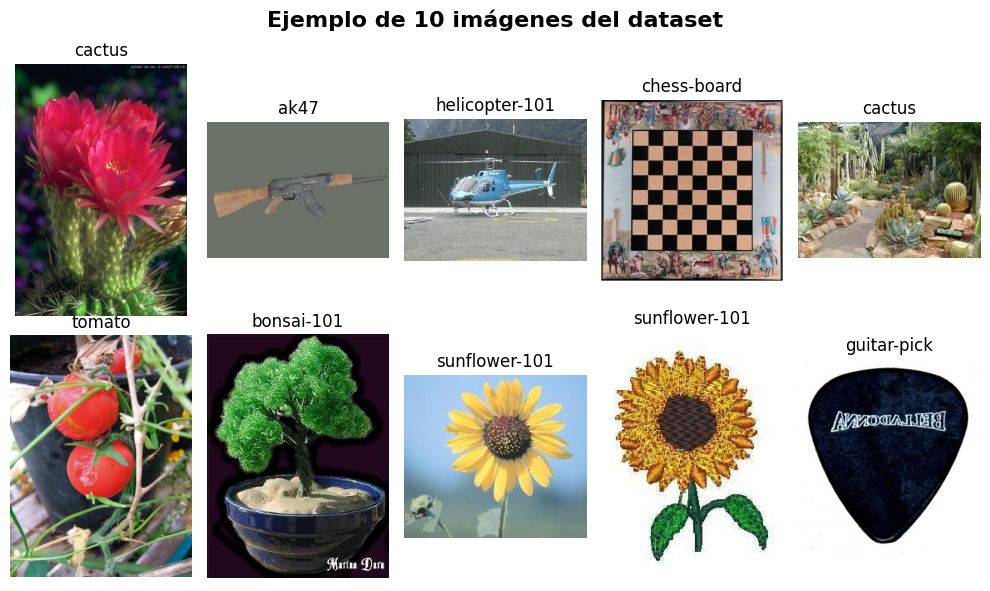

In [5]:
num_samples_to_display = 10
plt.figure(figsize=(10, 6))
for i in range(num_samples_to_display):
    index = randint(1, len(df))
    plt.subplot(2, 5, i + 1)
    plt.suptitle('Ejemplo de 10 imágenes del dataset', size=16, fontweight='demibold')
    plt.imshow(df.iloc[index, 0])
    plt.title(f'{df.iloc[index, 1]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

## <font color="#506F87" size=5.5><b>Detección de esquinas FAST</b></font>
<p><b>FAST</b> (Features from Accelerated Segment Test) fue propuesto por Edward Rosten y Tom Drummond en su artículo <i>Machine learning for high-speed corner detection</i> en 2006 (posteriormente lo revisaron en 2010). A continuación se presenta un resumen básico del algoritmo. </p> <p>
<ol type="1">
<li>Selecciona un pixel <span style="display: none;"></span><span tabindex="0" style=""><nobr><span style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.324em, -999.997em); top: -1.961em; left: 0em;"><span ><span  style="font-family: MathJax_Math-italic;">p</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 0.932em;"></span></span></nobr></span><script type="math/tex" >p</script> en la imagen que puede identificarse como punto de interés o no. Consideraremos su intensidad  <span style="display: none;"></span><span  tabindex="0" style=""><nobr><span   style="width: 1.074em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.896em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.182em, 1000.9em, 1.491em, -999.997em); top: -1.009em; left: 0em;"><span ><span  ><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span   style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span  style="font-size: 70.7%; font-family: MathJax_Math-italic;">p</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 1.015em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.425em; border-left: 0px solid; width: 0px; height: 1.289em;"></span></span></nobr></span><script type="math/tex" >I_p</script>.</li>
<li>Se selecciona un umbral adecuado <span style="display: none;"></span><span tabindex="0" style=""><nobr><span style="width: 0.479em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.36em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.134em, 1000.3em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span ><span  style="font-family: MathJax_Math-italic;">t</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em;"></span></span></nobr></span><script type="math/tex" >t</script>.</li>
<li><p >Consideramos un círculo de 16 píxeles alrededor del píxel objeto de la prueba. (Véase la imagen siguiente)</p>
<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/FAST_Corner_Detector.jpg/220px-FAST_Corner_Detector.jpg" alt="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/FAST_Corner_Detector.jpg/220px-FAST_Corner_Detector.jpg">
<div>
</div></div>
</li>
<li>El pixel <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.324em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">p</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 0.932em;"></span></span></nobr></span><script type="math/tex" >p</script> es una esquina si existe un conjunto de <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.717em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.6em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">n</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.718em;"></span></span></nobr></span><script type="math/tex" >n</script> píxeles contiguos (de los 16) que sean más claros que <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 3.039em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.503em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1002.44em, 2.682em, -999.997em); top: -2.199em; left: 0em;"><span  ><span  ><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span   style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span   style="font-size: 70.7%; font-family: MathJax_Math-italic;">p</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span   style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span style="font-family: MathJax_Math-italic; padding-left: 0.241em;">t</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.425em; border-left: 0px solid; width: 0px; height: 1.289em;"></span></span></nobr></span><script type="math/tex" >I_p + t</script>, o todos más oscuros que <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 3.039em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.503em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1002.44em, 2.682em, -999.997em); top: -2.199em; left: 0em;"><span  ><span  ><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span   style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span   style="font-size: 70.7%; font-family: MathJax_Math-italic;">p</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span   style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span   style="font-family: MathJax_Math-italic; padding-left: 0.241em;">t</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.425em; border-left: 0px solid; width: 0px; height: 1.289em;"></span></span></nobr></span><script type="math/tex" >I_p − t</script>. (En la imagen superior se muestran como líneas blancas discontinuas). <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.717em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.6em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span  ><span style="font-family: MathJax_Math-italic;">n</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.718em;"></span></span></nobr></span><script type="math/tex" >n</script> es 12 en este caso.</li>
<li>Un <b>test rápido</b> se propuso para excluir un gran número de no-esquinas. Esta prueba examina sólo los cuatro píxeles 1, 9, 5 y 13 (Primero se comprueba si 1 y 9 son demasiado claros u oscuros. Si es así, a continuación se comprueban 5 y 13). Si <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.324em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">p</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 0.932em;"></span></span></nobr></span><script type="math/tex" >p</script> es una esquina, entonces al menos tres de ellos deben ser más claros que <span class="MathJax_Preview" style="display: none;"></span><span tabindex="0" style=""><nobr><span   style="width: 3.039em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.503em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1002.44em, 2.682em, -999.997em); top: -2.199em; left: 0em;"><span  ><span  ><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span   style="font-size: 70.7%; font-family: MathJax_Math-italic;">p</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span   style="font-family: MathJax_Main; padding-left: 0.241em;">+</span><span style="font-family: MathJax_Math-italic; padding-left: 0.241em;">t</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.425em; border-left: 0px solid; width: 0px; height: 1.289em;"></span></span></nobr></span><script type="math/tex" >I_p + t</script> or darker than <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 3.039em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.503em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1002.44em, 2.682em, -999.997em); top: -2.199em; left: 0em;"><span  ><span  ><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.158em, 1000.48em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span   style="font-family: MathJax_Math-italic;">I<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.42em;"><span   style="font-size: 70.7%; font-family: MathJax_Math-italic;">p</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span   style="font-family: MathJax_Main; padding-left: 0.241em;">−</span><span   style="font-family: MathJax_Math-italic; padding-left: 0.241em;">t</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.425em; border-left: 0px solid; width: 0px; height: 1.289em;"></span></span></nobr></span><script type="math/tex" >I_p − t</script>. Si no se da ninguno de los dos casos, entonces <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.324em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">p</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 0.932em;"></span></span></nobr></span><script type="math/tex" >p</script> no es una esquina. El criterio de prueba del segmento completo puede aplicarse entonces a los candidatos aprobados examinando todos los píxeles del círculo. Este detector presenta un alto rendimiento, pero tiene varios puntos débiles:<ul>
<li>No rechaza suficientes candidatos para n &lt; 12.</li>
<li>La elección de los píxeles no es óptima porque su eficacia depende del orden de las preguntas y de la distribución de las apariciones en las esquinas.</li>
<li>Los resultados de las pruebas de alta velocidad son desechados.</li>
<li>Se detectan mútiples características adyacentes.</li>

In [6]:
kp_fast = []
for image in df.image:
    keypoints= fast_kp(image)
    kp_fast += [keypoints]

df['kp_fast'] = kp_fast

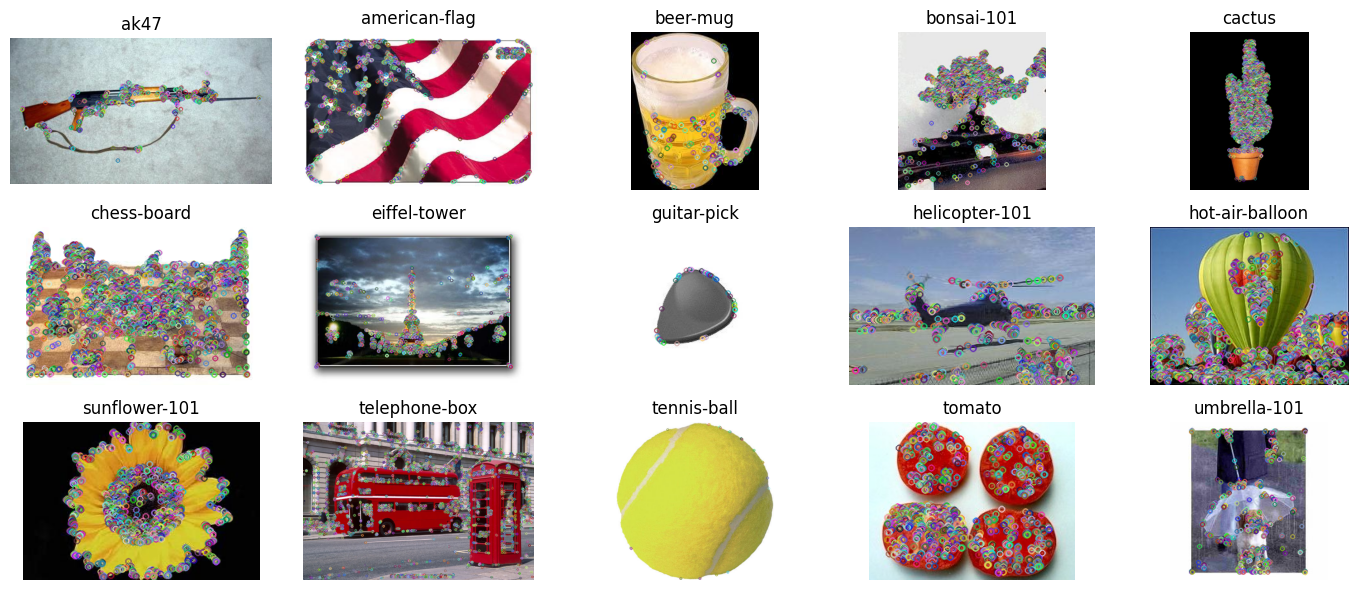

In [7]:
plt.figure(figsize=(14, 6))
for i, label in enumerate(class_names):
    image, kp = df[df['label'] == label].reset_index().loc[0, ['image', 'kp_fast']]

    plt.subplot(3, 5, i + 1)
    show_kp(image, label, kp)

plt.tight_layout()
plt.show()

## <font color="#506F87" size=5.5><b>Detectos y descriptores SIFT</b></font>
<p><strong>SIFT</strong> son las siglas de Scale-Invariant Feature Transform (transformación de características invariantes de escala) y fue presentada por primera vez en 2004 por D.Lowe, de la Universidad de Columbia Británica. SIFT es invariante a la escala y rotación de la imagen. Este algoritmo está patentado, por lo que este algoritmo se incluye en el módulo no libre en OpenCV. SIFT puede detectar características locales y también obtener descriptores de 128 números flotantes.</p>
<img alt="" width="700" height="394" loading="eager" role="presentation" src="https://miro.medium.com/v2/resize:fit:875/1*bPN9KN1Y7Lkl8_8wfNtQgA.png">
<br>
Las mayores ventajas de SIFT son
<ul ><li  data-selectable-paragraph=""><strong >Localidad: </strong>las características son locales, por lo que son resistentes a la oclusión y al desorden (sin segmentación previa).</li><li  data-selectable-paragraph=""><strong >Carácter distintivo:</strong> las características individuales pueden compararse con una gran base de datos de objetos.</li><li  data-selectable-paragraph=""><strong>Cantidad:</strong> se pueden generar muchas características para objetos de pequeño tamaño.</li><li  data-selectable-paragraph=""><strong >Eficiencia:</strong> Rendimiento casi de tiempo real.</li><li  data-selectable-paragraph=""><strong >Ampliabilidad: </strong>puede ampliarse fácilmente a una amplia gama de tipos de características diferentes, cada una de las cuales añade robustez.</li></ul>

In [8]:
kp_sift = []
desc_sift = []
for image in df.image:
    keypoints, descriptors = sift_descriptors_and_kp(image)
    kp_sift += [keypoints]
    desc_sift += [descriptors]

df['kp_sift'] = kp_sift
df['desc_sift'] = desc_sift


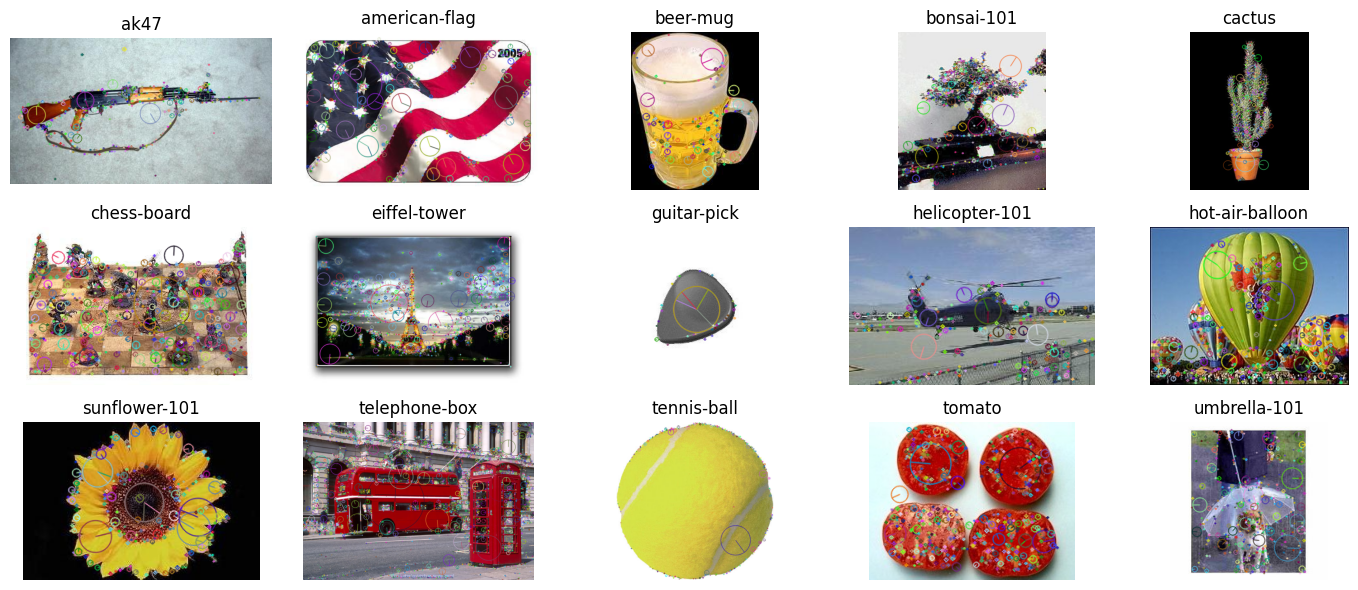

In [9]:
plt.figure(figsize=(14, 6))
for i, label in enumerate(class_names):
    image, kp = df[df['label'] == label].reset_index().loc[0, ['image', 'kp_sift']]

    plt.subplot(3, 5, i + 1)
    show_kp(image, label, kp)
plt.tight_layout()
plt.show()

## <font color="#506F87" size=5.5><b>Descriptores ORB</b></font>

<p><strong>ORB</strong> fue desarrollado por Ethan Rublee, Vincent Rabaud, Kurt Konolige y Gary R. Bradski en su artículo <i>ORB: An efficient alternative to SIFT or SURF</i> en 2011. Como dice el título, es una buena alternativa a SIFT y SURF en coste computacional, rendimiento de emparejamiento y principalmente las patentes. Sí, SIFT y SURF están patentados pero ORB no.</p>
<p>ORB es básicamente una fusión del detector de puntos clave FAST (descrito previamente) y el descriptor BRIEF con muchas modificaciones para mejorar el rendimiento. En primer lugar, utiliza FAST para encontrar los puntos clave y, a continuación, aplica la medida de esquinas de Harris para encontrar los N mejores puntos entre ellos. También utiliza la pirámide para producir características multiescala. Pero uno de los problemas es que FAST no calcula la orientación. ¿Qué pasa con la invariancia de rotación? Los autores propusieron la siguiente modificación.</p>
<p>Calcula el centroide ponderado por la intensidad de la ventana con la esquina situada en el centro. La dirección del vector desde esta esquina hasta el centroide indica la orientación. Para mejorar la invariancia de la rotación, los momentos se calculan con x e y, que deben estar en una región circular de radio <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">r</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.718em;"></span></span></nobr></span><script type="math/tex" >r</script>, donde <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.48em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">r</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.718em;"></span></span></nobr></span><script type="math/tex" >r</script> es el tamaño de la ventana.</p>
<p>Para los descriptores, ORB utiliza descriptores BRIEF. Pero BRIEF funciona mal con la rotación. Así que lo que hace ORB es "dirigir" BRIEF según la orientación de los puntos clave. Para cualquier conjunto de características de <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.717em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.598em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1000.6em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">n</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.718em;"></span></span></nobr></span><script type="math/tex" >n</script> test binarios localizados en <span class="MathJax_Preview" style="display: none;"></span><span tabindex="0" style=""><nobr><span style="width: 3.574em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.979em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.86em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span  ><span   style="font-family: MathJax_Main;">(</span><span  ><span style="display: inline-block; position: relative; width: 0.896em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.54em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span   style="font-family: MathJax_Math-italic;">x</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span   style="font-size: 70.7%; font-family: MathJax_Math-italic;">i</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span   style="font-family: MathJax_Main;">,</span><span   style="padding-left: 0.182em;"><span style="display: inline-block; position: relative; width: 0.836em; height: 0px;"><span style="position: absolute; clip: rect(3.396em, 1000.48em, 4.348em, -999.997em); top: -3.985em; left: 0em;"><span   style="font-family: MathJax_Math-italic;">y<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.479em;"><span   style="font-size: 70.7%; font-family: MathJax_Math-italic;">i</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span><span   style="font-family: MathJax_Main;">)</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr></span><script type="math/tex" >(x_i, y_i)</script>, define una matriz <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 2.86em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.384em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.372em, 1002.38em, 2.384em, -999.997em); top: -2.199em; left: 0em;"><span  ><span   style="font-family: MathJax_Main;">2</span><span style="font-family: MathJax_Main; padding-left: 0.241em;">×</span><span   style="font-family: MathJax_Math-italic; padding-left: 0.241em;">n</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 0.932em;"></span></span></nobr></span><script type="math/tex" >2 \times n</script>, <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span style="width: 0.836em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1000.66em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em;"></span></span></nobr></span><script type="math/tex" >S</script>, que contiene las coordenadas de los píxeles. Posteriormente, usando la orientación de la ventana <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1000.48em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">θ</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em;"></span></span></nobr></span><script type="math/tex" >\theta</script>, se usa la su matriz de rotación para rotar <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.836em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.658em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1000.66em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em;"></span></span></nobr></span><script type="math/tex" >S</script> para obtener la versión rotada <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 1.253em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.015em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.122em, 1001.01em, 1.372em, -999.997em); top: -1.009em; left: 0em;"><span  ><span  ><span style="display: inline-block; position: relative; width: 1.015em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span   style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span   style="font-size: 70.7%; font-family: MathJax_Math-italic;">θ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 1.015em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.218em;"></span></span></nobr></span><script type="math/tex" >S_\theta</script>.</p>
<p>ORB discretiza el ángulo en muestras que se toman cada <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 3.098em; display: inline-block;"><span style="display: inline-block; position: relative; width: 2.562em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.253em, 1002.5em, 2.622em, -999.997em); top: -2.199em; left: 0em;"><span  ><span   style="font-family: MathJax_Main;">2</span><span   style="font-family: MathJax_Math-italic;">π<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.003em;"></span></span><span  ><span  ><span   style="font-family: MathJax_Main;">/</span></span></span><span   style="font-family: MathJax_Main;">30</span></span><span style="display: inline-block; width: 0px; height: 2.205em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.354em; border-left: 0px solid; width: 0px; height: 1.361em;"></span></span></nobr></span><script type="math/tex" >2 \pi /30</script> (12 grados), y construye una tabla de patrones BRIEF precalculados. Siempre que la orientación del punto clave <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 0.598em; display: inline-block;"><span style="display: inline-block; position: relative; width: 0.479em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(1.074em, 1000.48em, 2.146em, -999.997em); top: -1.961em; left: 0em;"><span  ><span   style="font-family: MathJax_Math-italic;">θ</span></span><span style="display: inline-block; width: 0px; height: 1.967em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.068em; border-left: 0px solid; width: 0px; height: 1.004em;"></span></span></nobr></span><script type="math/tex" >\theta</script> sea coherente en todas las vistas, el conjunto correcto de puntos <span class="MathJax_Preview" style="display: none;"></span><span   tabindex="0" style=""><nobr><span   style="width: 1.253em; display: inline-block;"><span style="display: inline-block; position: relative; width: 1.015em; height: 0px; font-size: 120%;"><span style="position: absolute; clip: rect(0.122em, 1001.01em, 1.372em, -999.997em); top: -1.009em; left: 0em;"><span  ><span  ><span style="display: inline-block; position: relative; width: 1.015em; height: 0px;"><span style="position: absolute; clip: rect(3.098em, 1000.66em, 4.17em, -999.997em); top: -3.985em; left: 0em;"><span   style="font-family: MathJax_Math-italic;">S<span style="display: inline-block; overflow: hidden; height: 1px; width: 0.063em;"></span></span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span><span style="position: absolute; top: -3.807em; left: 0.598em;"><span   style="font-size: 70.7%; font-family: MathJax_Math-italic;">θ</span><span style="display: inline-block; width: 0px; height: 3.991em;"></span></span></span></span></span><span style="display: inline-block; width: 0px; height: 1.015em;"></span></span></span><span style="display: inline-block; overflow: hidden; vertical-align: -0.282em; border-left: 0px solid; width: 0px; height: 1.218em;"></span></span></nobr></span><script type="math/tex" >S_\theta</script> será usado para calcular el descriptor.</p>
<p>El paper afirma que ORB es mucho más rápido que SURF y SIFT y los descriptores ORB funciona mejor que SURF. ORB es una buena opción en dispositivos de baja potencia.</p>


In [10]:
desc_orb = []
for i in df.index:
    image, kp = df.iloc[i, 0], df.iloc[i, 2]
    descriptors = orb_descriptors(image, kp)
    desc_orb += [descriptors]

df['desc_ORB'] = desc_orb

## <font color="#506F87" size=5.5><b>Mapas de características obtenidos con CNN</b></font>
<div><p>Vamos a usar una CNN para extraer mapas de características, más concretamente <strong>VGG-16</strong>. VGG16 es una red neuronal convolucional entrenada con un subconjunto del conjunto de datos <a href="https://www.image-net.org/">ImageNet</a>, una colección de más de 14 millones de imágenes pertenecientes a 22.000 categorías. K. Simonyan and A. Zisserman propusieron

este modelo en el paper de 2015, <i>Very Deep Convolutional Networks for Large-Scale Image Recognition.</i> En el desafío de clasificación ImageNet de 2014, VGG16 alcanzó una precisión de clasificación del 92,7 %. Cuando utilizamos VGG-16 como extractor de características, eliminamos la última capa del modelo, que es la capa softmax responsable de predecir las categorías de ImageNet. La salida de la penúltima capa se utiliza como representación de características para cada imagen.
<section><div class="caption-image"><div><figure><divstyle=""><img height="319" loading="lazy" src="https://storage.googleapis.com/lds-media/images/vgg16-architecture.width-1200.jpg" width="1184"></div></figure></div><a class="zoom-in-img" href="https://storage.googleapis.com/lds-media/images/vgg16-architecture.width-1200.jpg" target="_blank"><svg enable-background="new 0 0 24 24" height="24" viewBox="0 0 24 24" width="24" xmlns="http://www.w3.org/2000/svg"><rect fill="none" height="24" width="24"></rect><polygon points="21,11 21,3 13,3 16.29,6.29 6.29,16.29 3,13 3,21 11,21 7.71,17.71 17.71,7.71"></polygon></svg></a></div></section>
<section><div>
<br>


-----
Cargamos el modelo preentrenado, que nos facilita la librería torchvision

In [ ]:
# Download pretrained model
model = models.vgg16(weights='DEFAULT')

In [ ]:
features = []
for image in df.image:
    image = cv2.resize(image, (300, 300))
    image = preprocessing_for_CNN(image)

    # Añadir el mapa de características a la lista, según su clase
    features.append(feature_map(model, image, layer='conv_11'))

df['CNN_features'] = features

## <font color="#506F87" size=5.5><b>Histrogramas de color</b></font>
<p>Los <strong>histogramas de color</strong> representan una de las primeras (y más sencillas) técnicas CBIR, permitiéndonos buscar entre imágenes basándonos en sus perfiles de color. Para comparar histogramas de color lo primero que tenemos que hacer es obtenerlos para las dos imágenes. Una vez lo tenemos, ponemos los tres histogramas de cada imagen en común (uno detrás de otro) y luego normalizamos ambos. Una vez normalizados podemos compararlos utilizando una métrica de distancia.</p>
<section><div class="caption-image"><div><figure><divstyle=""><img height="250" width="650" loading="lazy" src="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/04/opencv_image_histograms_color_flattened.png?lossy=2&strip=1&webp=1" width="1184"></div></figure></div><a class="zoom-in-img" href="https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/04/opencv_image_histograms_color_flattened.png?lossy=2&strip=1&webp=1" target="_blank"><svg enable-background="new 0 0 24 24" height="24" viewBox="0 0 24 24" width="24" xmlns="http://www.w3.org/2000/svg"><rect fill="none" height="24" width="24"></rect><polygon points="21,11 21,3 13,3 16.29,6.29 6.29,16.29 3,13 3,21 11,21 7.71,17.71 17.71,7.71"></polygon></svg></a></div></section>
<section>

In [ ]:
histograms = []
for image in df.image:
    histograms += [get_histogram(image)]

df['hist'] = histograms

## <font color="#506F87" size=5.5><b>Bag of Visual Words</b></font>
El modelo <strong>Bag of Words (BoW)</strong>, originalmente desarrollado para el procesamiento de textos, ha sido adaptado para su uso en procesamiento de imágenes, particularmente en  extracción de imágenes basada en contenido (CBIR). En CBIR con BoW, las imágenes son representadas como colecciones de "palabras" visuales o descriptores locales, como los SIFT. Estos descriptores son extraidos de las imágenes and cuantificados en un vocabulario predefindo ("palabras" visuales).</p>
<section><div class="caption-image"><div><figure><divstyle=""><img height="350" width="490" loading="lazy" src="https://miro.medium.com/v2/resize:fit:1250/1*QgI1t-7yJApi4vQigFgsLQ.jpeg" width="1184"></div></figure></div><a class="zoom-in-img" href="https://miro.medium.com/v2/resize:fit:1250/1*QgI1t-7yJApi4vQigFgsLQ.jpeg" target="_blank"><svg enable-background="new 0 0 24 24" height="24" viewBox="0 0 24 24" width="24" xmlns="http://www.w3.org/2000/svg"><rect fill="none" height="24" width="24"></rect><polygon points="21,11 21,3 13,3 16.29,6.29 6.29,16.29 3,13 3,21 11,21 7.71,17.71 17.71,7.71"></polygon></svg></a></div></section>
<section>

In [ ]:
tfidf = get_tfidf(df)
df['tfidf'] = tfidf.tolist()

## <font color="#506F87" size=5.5><b>Guardado de las features</b></font>

In [ ]:
del df['kp_fast']
del df['kp_sift']
df.iloc[:, :2].to_pickle('Images_df.pkl', compression={'method': 'gzip', 'compresslevel': 3, 'mtime': 1})
df.iloc[:, 2:].to_pickle('Features_df.pkl', compression={'method': 'gzip', 'compresslevel': 3, 'mtime': 1})

## <font color="#506F87" size=5.5><b>References</b></font>
<b>Documentation</b>
<br><font color="#506F87"></font>1. https://www.kaggle.com/datasets/jessicali9530/caltech256/data?select=256_ObjectCategories
<br> 2. https://keras.io/
<br> 3. https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
<br> 4. https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/
<br> 5. https://github.com/upm-classes/aapi_2023
<br> 6. https://opencv.org/
<br> 7. https://medium.com/data-breach/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40
<br> 8. https://www.pinecone.io/learn/series/image-search/color-histograms/
<br><br><b>Images</b>
<br> 1. https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/FAST_Corner_Detector.jpg/220px-FAST_Corner_Detector.jpg
<br> 2. https://miro.medium.com/v2/resize:fit:875/1*bPN9KN1Y7Lkl8_8wfNtQgA.png
<br> 3. https://storage.googleapis.com/lds-media/images/vgg16-architecture.width-1200.jpg
<br> 4. https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/04/opencv_image_histograms_color_flattened.png?lossy=2&strip=1&webp=1